# Not Rabbit Holes

This notebook will be used to do some small analyses throughout the project. 

## 1. Apply Hampel Filter Twice?

This code checks whether applying the Hampel filter on the beat-to-beat difference in heart rate during a ride results in more rows being filtered out than what is filtered out by simply applying it to the heart rates every second.

In [1]:
# Importing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.transformations.series.impute import Imputer

from opendata import OpenData

od = OpenData()

In [2]:
# Choosing a test sample. I will use an athlete's activity that I know has no missing data.

athlete = od.get_local_athlete("7780d1e6-26b2-411e-971f-8d35c56e65d8")
activities = list(athlete.activities())
activity = activities[0]

In [3]:
# Creating a pandas dataframe, adding hr as a column, and calculating the difference between consecutive heart rates
df = activity.data.copy()[["secs", "hr"]]

# Applying the Hampel filter to the raw heart rate data. This returns boolean values (outliers = True, inliers = false).
df["hr_filt_bool"] = HampelFilter(window_length=5, return_bool=True).fit_transform(
    df["hr"]
)

# Applying the Hampel filter to the raw heart rate data. This returns filtered values.
df["hr_filt"] = HampelFilter(window_length=5).fit_transform(df["hr"])

# Using linear interpolation to impute NaN values from the filtered heart rate data.
df["hr_filt_imputed"] = Imputer(method="linear").fit_transform(df["hr_filt"])

# Calculating second by second difference in filtered-imputed heart rate
df["hr_filt_imputed_diff"] = df["hr_filt_imputed"].diff()

# Applying hampel filter to the second by second difference in filtered and imputed heart rate data. This returns boolean values (outliers = True, inliers = false).
df["hr_filt_2_bool"] = HampelFilter(window_length=5, return_bool=True).fit_transform(
    df["hr_filt_imputed_diff"]
)

# Applying this boolean series to hr_filt_imputed to get hr_filt_2.
df["hr_filt_2"] = df["hr_filt_imputed"][~df["hr_filt_2_bool"]]

# Using linear interpolation to impute NaN values from the filterd heart rate data in hr_filt_2.
df["hr_filt_2_imputed"] = Imputer(method="linear").fit_transform(df["hr_filt_2"])

c:\Users\karka\anaconda3\envs\golden-cheetah\Lib\site-packages\sktime\transformations\series\outlier_detection.py:103: UserWarning: Series contains nan values, more nan might be
                added if there are outliers
  Z = self._transform_series(Z)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5149 entries, 0 to 5148
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   secs                  5149 non-null   int64  
 1   hr                    5149 non-null   int64  
 2   hr_filt_bool          5149 non-null   bool   
 3   hr_filt               4812 non-null   float64
 4   hr_filt_imputed       5149 non-null   float64
 5   hr_filt_imputed_diff  5148 non-null   float64
 6   hr_filt_2_bool        5149 non-null   bool   
 7   hr_filt_2             4300 non-null   float64
 8   hr_filt_2_imputed     5149 non-null   float64
dtypes: bool(2), float64(5), int64(2)
memory usage: 291.8 KB


In [5]:
df.head()

,secs,hr,hr_filt_bool,hr_filt,hr_filt_imputed,hr_filt_imputed_diff,hr_filt_2_bool,hr_filt_2,hr_filt_2_imputed
0,0,104,False,104.0,104.0,NaN,True,NaN,104.0
1,1,104,False,104.0,104.0,0.0,False,104.0,104.0
2,2,104,False,104.0,104.0,0.0,False,104.0,104.0
3,3,104,False,104.0,104.0,0.0,False,104.0,104.0
4,4,105,False,105.0,105.0,1.0,True,NaN,104.5


In [6]:
# Checking whether the two boolean arrays are the same.
print((df["hr_filt_bool"] == df["hr_filt_2_bool"]).all())

# Counting the number of differences between the two boolean arrays.
int((df["hr_filt_bool"] != df["hr_filt_2_bool"]).sum())

False


1182

The two boolean arrays, *hr_filt_bool* and *hr_filt_2_bool* are not identical. This indicates that applying the hampel filter twice, the first time on the raw heart rate values and again on their row-wise difference (after imputing), results in more values being filtered out. Next, I will plot the original heart rate series against the single filtered and doubly filtered heart rate series for a visual understanding of what is happening. 

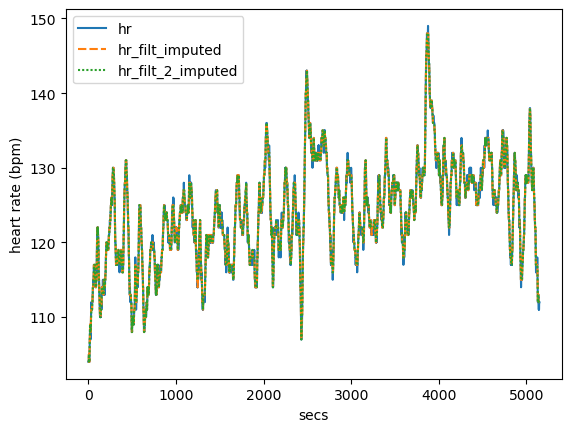

In [7]:
# Plotting hr, hr_filt_imputed, and hr_filt_2_imputed on a seaborn lineplot.
df_plot = df[["secs", "hr", "hr_filt_imputed", "hr_filt_2_imputed"]]
df_plot.set_index("secs", inplace=True)

fig = sns.lineplot(data=df_plot)
fig.set_xlabel("secs")
fig.set_ylabel("heart rate (bpm)")
plt.show()


In [10]:
# Creating a plotly.express plot to look for differences between the three series.
fig = px.line(data_frame=df_plot)
fig.show()
fig.write_html(r"..\data\interim\single_v_multiple_filtering.html")